# Independent Distribution

> In this post, we will find the meaning of the independent distribution, which is the bridge between univariate distribution and multivariate distribution. This is the summary of lecture "Probabilistic Deep Learning with Tensorflow 2" from Imperial College London.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Coursera, Tensorflow_probability, ICL]
- image: images/independent_from_bivariate.png

## Packages

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

tfd = tfp.distributions
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
print("Tensorflow Version: ", tf.__version__)
print("Tensorflow Probability Version: ", tfp.__version__)

Tensorflow Version:  2.5.0
Tensorflow Probability Version:  0.13.0


## Independent Distribution

Actually, the Independent distribution is not a formal name of specific distribution. In tensorflow probability, `Independent` distribution is that converts from batch of univariate distribution to multivariate distribution. In previous notebook, you may see that when the batch univariate distribution is formed, its shape is same as multivariate distribution. If we can define the index of batch size to be reinterpret, we can convert it.

In [4]:
# Start by defining a batch of two univariate Gaussians, then
# Combine them into a bivariate Gaussian with independent components

locs = [-1., 1]
scales = [0.5, 1.]

batched_normal = tfd.Normal(loc=locs, scale=scales)

In [5]:
# Univariate distribution

t = np.linspace(-4, 4, 10000)
# each column is a vector of densities for one distribution
densities = batched_normal.prob(np.repeat(t[:, np.newaxis], 2, axis=1))

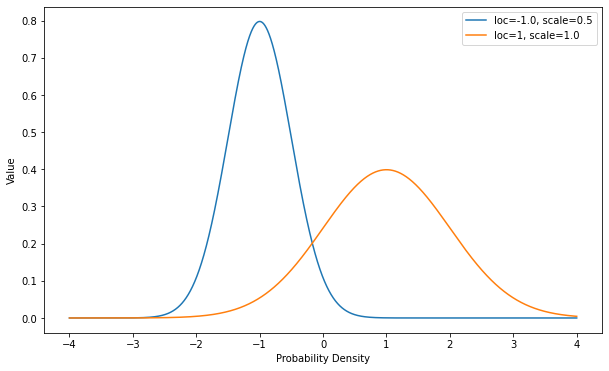

In [7]:
sns.lineplot(x=t, y=densities[:, 0], label='loc={}, scale={}'.format(locs[0], scales[0]))
sns.lineplot(x=t, y=densities[:, 1], label='loc={}, scale={}'.format(locs[1], scales[1]))
plt.xlabel('Probability Density')
plt.ylabel('Value')
plt.legend(loc='best')
plt.show()

In [8]:
# Check their batch_shape and event_shape

batched_normal

<tfp.distributions.Normal 'Normal' batch_shape=[2] event_shape=[] dtype=float32>

As you can see, this distribution has batch_shape of 2. So How can we convert it to identical-shaped multivariate distribution?

In [9]:
# Use Independent to convert batch shape to the event shape

bivariate_normal_from_Independent = tfd.Independent(batched_normal, reinterpreted_batch_ndims=1)
bivariate_normal_from_Independent

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[] event_shape=[2] dtype=float32>

The meaning is that, the batch dimension of specific distribution will be regarded as events in the new distribution. So you can that the output distribution has the shape of 2, not batch size of 2. In order to visualize it, we can use joint plot.

In [10]:
samples = bivariate_normal_from_Independent.sample(10000)

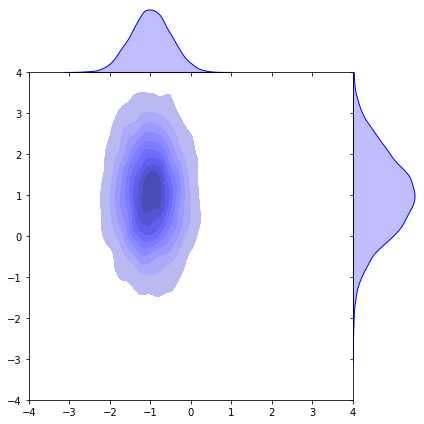

In [12]:
sns.jointplot(x=samples[:, 0], y=samples[:, 1], kind='kde', space=0, color='b', xlim=[-4, 4], ylim=[-4, 4], fill=True)
plt.show()

So is it the same as multivariate one? Let's check this out.

In [13]:
# Use MultivariateNormalDiag to create the equivalent distribution
# Note that diagonal covariance matrix => no correlation => independence (for the multivariate normal distribution)

bivariate_normal_from_Multivariate = tfd.MultivariateNormalDiag(loc=locs, scale_diag=scales)
bivariate_normal_from_Multivariate

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

In [14]:
samples = bivariate_normal_from_Multivariate.sample(10000)

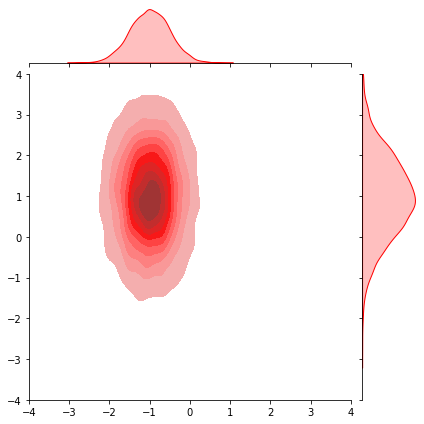

In [16]:
sns.jointplot(x=samples[:, 0], y=samples[:, 1], kind='kde', color='r', xlim=[-4, 4], ylim=[-4, 4], fill=True)
plt.show()

### Shifting batch dimensions to event dimensions using `reinterpreted_batch_ndims`

So we need to understand the usage of `reinterpreted_batch_ndims`, since the output distribution is different in terms of this parameter.

In [36]:
# Demonstrate usage of reinterpreted_batch_ndims
# By default, all batch dims except the first are transferred to event dims

loc_grid = [[-100., -100.],
            [100., 100.],
            [0., 0.]]

scale_grid = [[1., 10.],
              [1., 10.],
              [1., 1.]]

normals_batch_3by2_event_1 = tfd.Normal(loc=loc_grid, scale=scale_grid)
normals_batch_3by2_event_1

<tfp.distributions.Normal 'Normal' batch_shape=[3, 2] event_shape=[] dtype=float32>

In [37]:
np.array(loc_grid).shape

(3, 2)

We now have a batch of 3 bivariate normal distributions, and each paramterized by a column of our original parameter grid.

In [38]:
normals_batch_3_event_2 = tfd.Independent(normals_batch_3by2_event_1)
normals_batch_3_event_2

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[3] event_shape=[2] dtype=float32>

In [39]:
# Evaluate log prob
normals_batch_3_event_2.log_prob(loc_grid)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-4.1404624, -4.1404624, -1.837877 ], dtype=float32)>

And we can also reinterpret all batch dimensions as event dimensions.

In [40]:
normals_batch_1_event_3by2 = tfd.Independent(normals_batch_3by2_event_1, reinterpreted_batch_ndims=2)
normals_batch_1_event_3by2

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[] event_shape=[3, 2] dtype=float32>

In [41]:
# Take log_probs

normals_batch_1_event_3by2.log_prob(loc_grid)

<tf.Tensor: shape=(), dtype=float32, numpy=-10.118802>

## Using `Independent` to build a Naive Bayes classifier

### Introduction to `newsgroup` dataset

In this tutorial, just load the dataset, fetch train/test splits, probably choose a subset of the data.

Construct the class conditional feature distribution (with Independent, using the Naive Bayes assumption) and sample from it.

We can just use the ML estimates for parameters, in later tutorials we will learn them.

In [42]:
# Convenience function for retrieving the 20 newsgroups data set

# Usenet was a forerunner to modern internet forums
# Users could post and read articles
# Newsgroup corresponded to a topic
# Example topics in this data set: IBM computer hardware, baseball
# Our objective is to use an article's contents to predict its newsgroup,
# a 20-class classification problem.

# 18000 newsgroups, posts on 20 topics
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

In [43]:
# Get the train data
newsgroup_data = fetch_20newsgroups(data_home='./dataset/20_Newsgroup_Data/', subset='train')

In [45]:
print(newsgroup_data['DESCR'])

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality

In [46]:
# Example article

print(newsgroup_data['data'][0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [48]:
# Associated label
label = newsgroup_data['target'][0]
label

7

In [49]:
# The name of label
newsgroup_data['target_names'][label]

'rec.autos'

It means that this news is related on cars (or autos).

To handle this ML pipeline, we need to preprocess it.

In [50]:
n_documents = len(newsgroup_data['data'])

cv = CountVectorizer(input='content', binary=True, max_df=0.25, min_df=1.01 / n_documents)

In [51]:
binary_bag_of_words = cv.fit_transform(newsgroup_data['data'])

In [52]:
# Check shape
binary_bag_of_words.shape

(11314, 56365)

We can check the output by using inverse transform from CountVectorizer.

In [55]:
cv.inverse_transform(binary_bag_of_words[0, :])

[array(['lerxst', 'wam', 'umd', 'where', 'thing', 'car', 'rac3',
        'maryland', 'college', 'park', '15', 'wondering', 'anyone',
        'could', 'enlighten', 'saw', 'day', 'door', 'sports', 'looked',
        'late', '60s', 'early', '70s', 'called', 'bricklin', 'doors',
        'were', 'really', 'small', 'addition', 'front', 'bumper',
        'separate', 'rest', 'body', 'tellme', 'model', 'name', 'engine',
        'specs', 'years', 'production', 'made', 'history', 'whatever',
        'info', 'funky', 'looking', 'please', 'mail', 'thanks', 'il',
        'brought', 'neighborhood'], dtype='<U80')]

And it will be more convenient if this matrix is handled with dictionary.

In [57]:
inv_voc = {v:k for k, v in cv.vocabulary_.items()}

#### A Naive Bayes classifier for `newsgroup`

Each feature vector $x$ is a list of indicators for whether a word appears in the article. $x_i$ is 1 if the $i$th word appears, and 0 otherwise. `inv_voc` matches word indices $i$ to words.

Each label $y$ is a value in $0, 1, \ldots, 19$.

The parts of a naive Bayes classifier for this problem can be summarised as:  


- A probability distribution for the feature vector by class, $p(x|y = j)$ for each $j = 0, 1, \ldots, 19$. These probability distributions are assumed to have independent components: we can factorize the joint probability as a product of marginal probabilities
\begin{equation}
    p(x|y = j) = \prod_{i=1}^d p(x_i|y = j)
\end{equation}
These marginal probability distributions are Bernoulli distributions, each of which has a single parameter $\theta_{ji} := p(x_i = 1|y = j)$. This parameter is the probability of observing word $i$ in an article of class $j$. 

- We will use the Laplace smoothed maximum likelihood estimate to compute these parameters. Laplace smoothing involves adding small counts to every feature for each class. Else, if a feature did not appear in the training set of a class, but then we observed it in our test data the log probability would be undefined.

- A collection of class prior probabilities $p(y = j)$. These will be set by computing the class base rates in the training set.  


- A function for computing the probability of class membership via Bayes' theorem:  

\begin{equation}
    p(y = j|x) = \frac{p(x|y = j)p(y = j)}{p(x)}
\end{equation}

Keep in mind that we need to consider about the vocabulary exists in test set, but not in training set.

In [58]:
# Compute the parameter estimates (adjusted fraction of documents in class that contain word)

n_classes = newsgroup_data['target'].max() + 1
y = newsgroup_data['target']
n_words = binary_bag_of_words.shape[1]

In [59]:
# The parameter of Laplace Smoothing
alpha = 1e-6 

# Stores parameter values - prob. word given class
theta = np.zeros([n_classes, n_words])

for c_k in range(n_classes):
    class_mask = (y == c_k)
    # The number of articles in class
    N = class_mask.sum() 
    theta[c_k, :] = (binary_bag_of_words[class_mask, :].sum(axis=0) + alpha) / (N + alpha * 2)

In [61]:
# Check whether the most probable word in each class is reasonable

# Most probable word for each class
most_probable_word_i = theta.argmax(axis=1) 

for j, i in enumerate(most_probable_word_i):
    print("Most probable word in class {} is \"{}\".".format(newsgroup_data['target_names'][j], inv_voc[i]))

Most probable word in class alt.atheism is "people".
Most probable word in class comp.graphics is "graphics".
Most probable word in class comp.os.ms-windows.misc is "windows".
Most probable word in class comp.sys.ibm.pc.hardware is "thanks".
Most probable word in class comp.sys.mac.hardware is "mac".
Most probable word in class comp.windows.x is "window".
Most probable word in class misc.forsale is "sale".
Most probable word in class rec.autos is "car".
Most probable word in class rec.motorcycles is "dod".
Most probable word in class rec.sport.baseball is "he".
Most probable word in class rec.sport.hockey is "ca".
Most probable word in class sci.crypt is "clipper".
Most probable word in class sci.electronics is "use".
Most probable word in class sci.med is "reply".
Most probable word in class sci.space is "space".
Most probable word in class soc.religion.christian is "god".
Most probable word in class talk.politics.guns is "people".
Most probable word in class talk.politics.mideast is 

Now it's time to build the model of each keyword with distribution. We will assume that its dataset is bernoulli distribution.

In [62]:
# Define a distribution for each class
batch_of_bernoullis = tfd.Bernoulli(probs=theta)

In [63]:
p_x_given_y = tfd.Independent(batch_of_bernoullis, reinterpreted_batch_ndims=1)
p_x_given_y

<tfp.distributions.Independent 'IndependentBernoulli' batch_shape=[20] event_shape=[56365] dtype=int32>

In [64]:
# Take a sample of words from each class
samples = p_x_given_y.sample(10)
samples

<tf.Tensor: shape=(10, 20, 56365), dtype=int32, numpy=
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0,

In [65]:
# Choose a specific class to test
chosen_class = 10
newsgroup_data['target_names'][chosen_class]

'rec.sport.hockey'

In [67]:
# Indicators for words that appear in the sample
class_sample = samples[:, chosen_class, :]
class_sample

<tf.Tensor: shape=(10, 56365), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>

In [69]:
# Perform inverse transform to test quality of fit
cv.inverse_transform(class_sample)[0]

array(['1076', '108', '12', '18', '184', '1984', '259', '32', '48', '514',
       '54', '97', '_are_', 'admirals', 'advance', 'affinity', 'after',
       'against', 'alberta', 'attitude', 'babych', 'basis', 'before',
       'best', 'blues', 'both', 'cci632', 'ccohen', 'central', 'champs',
       'closed', 'computer', 'consistently', 'couple', 'designated',
       'development', 'devils', 'distribution', 'div', 'does', 'doherty',
       'droopy', 'during', 'effort', 'engineering', 'entity', 'every',
       'everyone', 'expensive', 'final', 'finland', 'first', 'foster',
       'franchise', 'gballent', 'georgia', 'gilhen', 'goals',
       'goaltenders', 'god', 'going', 'good', 'guy', 'had', 'haha',
       'happened', 'he', 'head', 'home', 'however', 'kick', 'looks',
       'maine', 'models', 'mom', 'need', 'nne', 'ny', 'off', 'ot',
       'penguins', 'pittsburgh', 'play', 'played', 'rangers', 'really',
       'record', 'rex', 'right', 'san', 'stadium', 'still', 'streak',
       'style', '

Based on google search, the first sentence of sample data contains keywords related on ice hockey. For example, `ccohen` will be Colby Cohen in NHL. and `goaltender` is the player reponsible for preventing hockey puck.